In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import cv2
import pandas as pd
import skimage

plt.style.use('ggplot')

In [4]:
DATASET_DIR="../dataset/LPW_frames/LPW/"

In [5]:
def plot_cumulative_error(algorithm_errors : list[np.ndarray],
                          titles : list[str],
                          ) -> None:
    total_samples = len(algorithm_errors[0])
    errors = []
    for err in algorithm_errors:
        errors.extend(err)
    x_values = sorted(set(errors))
    
    fig, ax = plt.subplots()
   
    # Plot cumulative error distribution
    for errors, title in zip(algorithm_errors, titles):
        alg_err_dist = [sum(1 for error in errors if error <= x) / total_samples for x in x_values]
        ax.plot(x_values, alg_err_dist, label=title)
        
    ax.set_ylabel("Percentage of Images")
    ax.set_xlabel("Detection Error")
    ax.set_title("Cumulative Error Distribution of Each Algorithm")

    # Set tick labels with units using formatters
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}px"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y*100:.0f}%"))

    ax.legend()
    plt.show()


In [6]:
def dummy_method(image: np.ndarray):
    return image.shape[0]//2, image.shape[1]//2

### NOTA

Hay mas anotaciones que imagenes, fijarse bien el tema de las anotaciones 
como se indexan y eso, a que frame corresponde cada point anotation

In [7]:
import glob

# 132000 frames en total = 22(subcarpetas) * 3(videos_en_subcarpeta) * 2000(frames_por_video)

subfolder="1"
img_paths = glob.glob(f"{DATASET_DIR}/{subfolder}/{subfolder}_frames/*.png")

annot_path = f"{DATASET_DIR}/{subfolder}/{subfolder}.txt"
ground_truth = pd.read_csv(annot_path, sep=" ", header=None)
ground_truth.columns = ["x", "y"]

results = []
for index, path in enumerate(img_paths):
    img = cv2.imread(path)
    error = np.sqrt(np.sum((ground_truth.iloc[index].values - dummy_method(img))**2))
    results.append(error)
    
rand_errs = np.random.randint(0, 300, size=len(results))
rand_errs2 = np.random.randint(0, 300, size=len(results))
plot_cumulative_error([results, rand_errs, rand_errs2], 
                      ["Dummy", "Random1", "Random2"])

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/LPW_frames/LPW//1/1.txt'

### Algoritmo 1

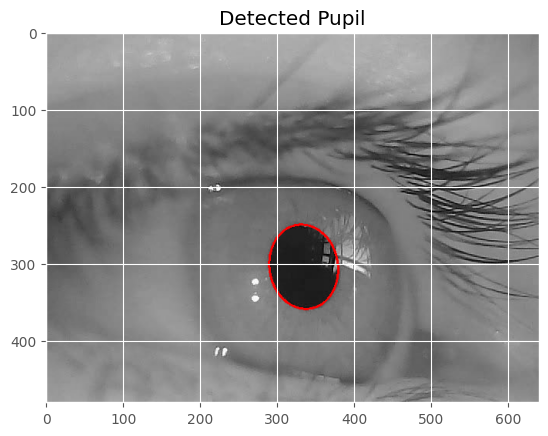

(334, 304)


In [18]:
def find_pupil(image):
    if peak_detected(image):
        edges = edge_pupil_center_detection(image)
        if (edges is not None):
            ellipsis, center = edges
            return ellipsis, center
        else:
            # Thresholding and coarse positioning
            return None
    else:
        # Thresholding and coarse positioning
        return None


# Returns True if there is a peak in the histogram of an image
def peak_detected(image, th=200, mu=10):
    # Calculate the histogram of the image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Calculate the average intensity of the image
    avg_intensity = np.mean(image)

    # If there is a peak in the histogram, return True
    for i in range(256):
        if hist[i] > th and hist[i] > mu * avg_intensity:
            return True
    
    return False

# Returns the ellipsis that best fits the pupil with its center, or None if no pupil is found
def edge_pupil_center_detection(image):
    # Apply Gaussian filtering for smoothing
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(smoothed, 50, 100) # Adjust the threshold as needed

    # Find the contours of the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the ellipses that best fit the contours
    ellipses = []
    for contour in contours:
        if len(contour) >= 30:
            ellipse = cv2.fitEllipse(contour)

            # Unpack the ellipse parameters
            (center_x, center_y), (major_axis, minor_axis), angle = ellipse
            
            # Convert the parameters to integer values
            center = (int(center_x), int(center_y))
            axes = (int(major_axis / 2), int(minor_axis / 2))

            # Calculate the size of the square based on a scale factor
            scale_factor = 0.4
            square_size = int(min(axes) * scale_factor)
            
            # Define the coordinates of the square
            x = center[0] - square_size // 2
            y = center[1] - square_size // 2
            
            # Extract the square region of interest (ROI) from the image
            roi = image[y:y+square_size, x:x+square_size]
            
            # Calculate the percentage of black pixels within the ROI
            black_pixels = np.sum(roi < 45)
            total_pixels = roi.size
            if total_pixels == 0:
                black_pixels_percentage = 0
            else:
                black_pixels_percentage = black_pixels / total_pixels

            # If the percentage of black pixels is greater than 90%, then the ellipse is a pupil
            if black_pixels_percentage > 0.9:
                ellipses.append(ellipse)

    # If no ellipses are found, return None. Otherwise, return the largest ellipse with its center
    if len(ellipses) == 0:
        return None
    else:
        return find_largest_ellipsis(ellipses)

# Returns the largest ellipse with its center
def find_largest_ellipsis(ellipses):
    # Initialize variables for tracking the largest ellipse
    largest_area = 0
    largest_ellipse = None
    center = None

    for ellipse in ellipses:
        # Unpack the ellipse parameters
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        
        # Convert the parameters to integer values
        c = (int(center_x), int(center_y))
        axes = (int(major_axis / 2), int(minor_axis / 2))

        # Calculate the area of the ellipse contour
        contour_area = np.pi * (axes[0] / 2) * (axes[1] / 2)

        # Check if the current ellipse has a larger area than the previous largest ellipse
        if contour_area > largest_area:
            largest_area = contour_area
            largest_ellipse = ellipse
            center = c

    return largest_ellipse, center

# Draw the ellipsis on the image
def draw_ellipsis(image: np.ndarray, ellipsis):
    if ellipsis is not None:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        cv2.ellipse(image, ellipsis, (255, 0, 0), 2)

    plt.imshow(image) 
    plt.title("Detected Pupil")
    plt.show()

# Testing
image = cv2.imread(f"{DATASET_DIR}/{subfolder}/{subfolder}_frames/frame_1.png", 0) # Read as grayscale

if find_pupil(image) is not None:
    ellipsis, center = find_pupil(image)
    draw_ellipsis(image, ellipsis)
    print(center)
else:
    plt.imshow(image, cmap="gray")
    plt.title("No Pupil Detected")
    plt.show()

../dataset/LPW_frames/LPW//2//10_frames/frame_1.png
../dataset/LPW_frames/LPW//2//10_frames/frame_2.png
../dataset/LPW_frames/LPW//2//10_frames/frame_3.png
../dataset/LPW_frames/LPW//2//10_frames/frame_4.png
../dataset/LPW_frames/LPW//2//10_frames/frame_5.png
../dataset/LPW_frames/LPW//2//10_frames/frame_6.png
../dataset/LPW_frames/LPW//2//10_frames/frame_7.png
../dataset/LPW_frames/LPW//2//10_frames/frame_8.png
../dataset/LPW_frames/LPW//2//10_frames/frame_9.png
../dataset/LPW_frames/LPW//2//10_frames/frame_10.png
../dataset/LPW_frames/LPW//2//10_frames/frame_11.png
../dataset/LPW_frames/LPW//2//10_frames/frame_12.png
../dataset/LPW_frames/LPW//2//10_frames/frame_13.png
../dataset/LPW_frames/LPW//2//10_frames/frame_14.png
../dataset/LPW_frames/LPW//2//10_frames/frame_15.png
../dataset/LPW_frames/LPW//2//10_frames/frame_16.png
../dataset/LPW_frames/LPW//2//10_frames/frame_17.png
../dataset/LPW_frames/LPW//2//10_frames/frame_18.png
../dataset/LPW_frames/LPW//2//10_frames/frame_19.png
..

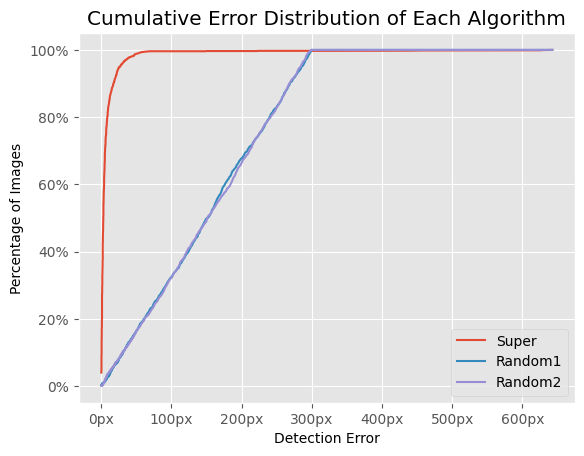

In [39]:
from pathlib import Path

def error_fn(x : float, y : float) -> float:
    return np.sqrt(np.sum((x - y)**2))

dataset_path = DATASET_DIR
MAX_FOLDER = 3 # <23

results = []
for subfolder_idx in range(1, MAX_FOLDER):
    subfolder = f"{dataset_path}/{subfolder_idx}/"
    
    for annot_path in Path(subfolder).glob("*.txt"):
        ground_truth = pd.read_csv(annot_path, sep=" ", header=None)
        ground_truth.columns = ["x", "y"]

        video_number = annot_path.stem
        for frame in range(1, 2001):
            img = cv2.imread(f"{subfolder}/{video_number}_frames/frame_{frame}.png")
            pupil = find_pupil(img)
            if pupil is None:
                continue
            x, y = ground_truth.iloc[frame-1].values
            _, (c_x, c_y) = pupil
            error = error_fn(c_x - x, c_y - y)
            results.append(error)

    

rand_errs = np.random.randint(0, 300, size=len(results))
rand_errs2 = np.random.randint(0, 300, size=len(results))
plot_cumulative_error([results, rand_errs, rand_errs2], 
                      ["Super", "Random1", "Random2"])

idea mejorar deteccion pupila.
tomar ventana de n pixeles a cada lado del centro de la elipse encontrada y verificar que el color dentro de la elipse sea negro (np.count_nonzero(window==0))


In [ ]:
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import os
import pandas as pd
import numpy as np

def error_fn(x : float, y : float) -> float:
    return np.sqrt(np.sum((x - y)**2))

def process_subfolder(subfolder_idx):
    subfolder = f"{dataset_path}/{subfolder_idx}/"
    
    for annot_path in Path(subfolder).glob("*.txt"):
        ground_truth = pd.read_csv(annot_path, sep=" ", header=None)
        ground_truth.columns = ["x", "y"]

        video_number = annot_path.stem
        for frame in range(1, 2001):
            img = cv2.imread(f"{subfolder}/{video_number}_frames/frame_{frame}.png")
            pupil = find_pupil(img)
            if pupil is None:
                continue
            x, y = ground_truth.iloc[frame-1].values
            _, (c_x, c_y) = pupil
            error = error_fn(c_x - x, c_y - y)
            results.append(error)
            
if __name__ == "__main__":
    dataset_path = DATASET_DIR
    MAX_FOLDER = 23  # <23

    results = []

    with ProcessPoolExecutor() as executor:
        for subfolder_idx in range(1, MAX_FOLDER):
            future = executor.submit(process_subfolder, subfolder_idx)
            results.append(future)

    # Gather results from all the processes
    final_results = []
    for future in results:
        final_results.extend(future.result())

### Algoritmo 2



error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'findContours'
> Overload resolution failed:
>  - image data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'image'


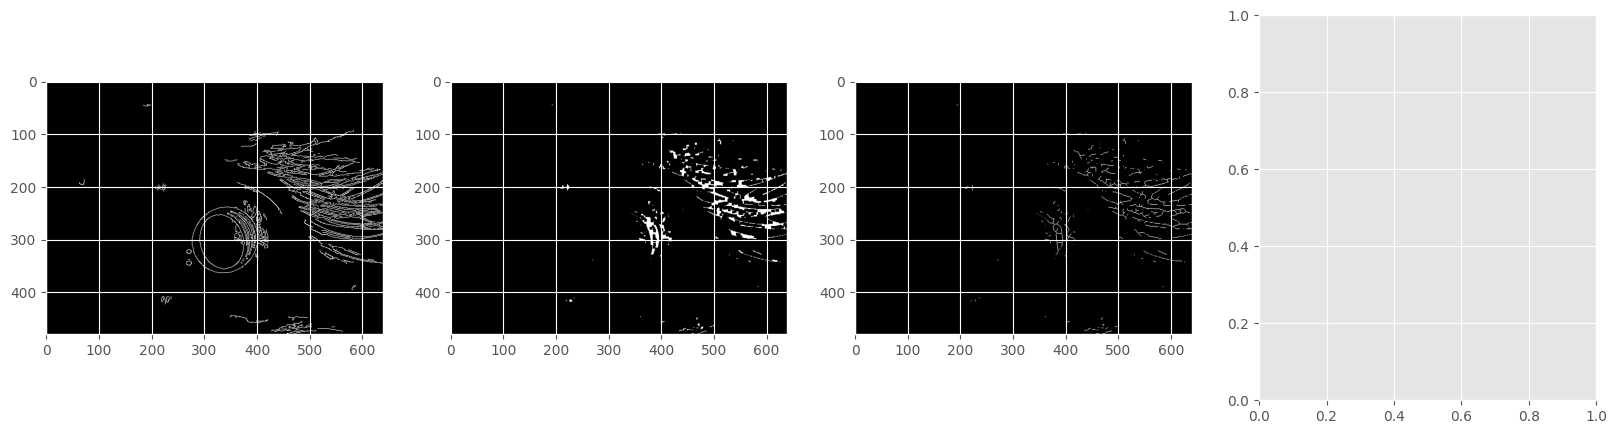

In [291]:
#DEBUG
fig, ax = plt.subplots(1,4, figsize=(20, 5))
##

threshold = 200
mu = 10
# histograma de imagen normalizada entre 0 y 255
histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
# chequear existencia de pico en histograma
avg_intensity = np.mean(image)
peak_detected = False
for i in range(256):
    if histogram[i] > threshold and histogram[i] > mu * avg_intensity:
        peak_detected = True
        break

# SI FUE DETECTADO UN PICO
gray = image
# Step (a): Apply Canny edge filter
edges = cv2.Canny(gray, 50, 150)

ax[0].imshow(edges, cmap='gray')

# Step (b): Remove edge pixels with less than two neighbors and angles between neighbors <= 90 degrees
kernel = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]], dtype=np.uint8)
filtered_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
filtered_edges = cv2.morphologyEx(filtered_edges, cv2.MORPH_ERODE, kernel)

ax[1].imshow(filtered_edges, cmap='gray')

# # Step (c): Thin the remaining connected edge pixels
# thinned_edges = cv2.ximgproc.thinning(filtered_edges)
thinned_edges = skimage.morphology.thin(filtered_edges, max_num_iter=None)

ax[2].imshow(thinned_edges, cmap='gray')

# # Step (c): Thin the remaining connected edge pixels
# thinned_edges = morphology.skeletonize(filtered_edges)

# Step (d): Remove pixels connecting two lines orthogonally
#final_edges = thinned_edges.astype(np.uint8) * 255
final_edges = thinned_edges


contours, _ = cv2.findContours(final_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
# plt.imshow(image)
ellipses = []
for contour in contours:
    if len(contour) >= 30:
        ellipse = cv2.fitEllipse(contour)

        # Unpack the ellipse parameters
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        
        # Convert the parameters to integer values
        center = (int(center_x), int(center_y))
        axes = (int(major_axis / 2), int(minor_axis / 2))
        
        # Calculate the size of the square based on a scale factor
        scale_factor = 0.4
        square_size = int(min(axes) * scale_factor)
        
        # Define the coordinates of the square
        x = center[0] - square_size // 2
        y = center[1] - square_size // 2
        
        # Extract the square region of interest (ROI) from the image
        roi = image[y:y+square_size, x:x+square_size]
        
        # Calculate the percentage of black pixels within the ROI
        black_pixels = np.sum(roi < 45)
        total_pixels = roi.size
        black_pixels_percentage = black_pixels / total_pixels

        if black_pixels_percentage > 0.95:
            ellipses.append(ellipse)

draw_ellipses(image, ellipses)


# # Step (d): Remove pixels connecting two lines orthogonally
# final_edges = cv2.ximgproc.ridgeDetection(thinned_edges)

# Step (e): Remove lines close to their centroid
# contours, _ = cv2.findContours(final_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for contour in contours:
#     # Calculate the centroid of the contour
#     moments = cv2.moments(contour)
#     cx = int(moments['m10'] / moments['m00'])
#     cy = int(moments['m01'] / moments['m00'])

#     # Remove lines close to the centroid
#     if cv2.pointPolygonTest(contour, (cx, cy), True) >= 0:
#         cv2.drawContours(final_edges, [contour], 0, 0, thickness=cv2.FILLED)

# ax[3].imshow(final_edges, cmap='gray')
# plt.show()

# # Step (f): Find the longest line containing the darkest pixels
# lines = cv2.ximgproc.createFastLineDetector().detect(final_edges)
# lines = sorted(lines, key=lambda x: x[2], reverse=True)  # Sort by line length in descending order

# darkest_line = None
# max_darkness = 0
# for line in lines:
#     x1, y1, x2, y2 = map(int, line[:4])
#     darkness = np.mean(gray[min(y1, y2):max(y1, y2), min(x1, x2):max(x1, x2)])

#     if darkness > max_darkness:
#         darkest_line = line
#         max_darkness = darkness

# if darkest_line is not None:
#     # Extract the endpoints of the darkest line as pupil coordinates
#     x1, y1, x2, y2 = map(int, darkest_line[:4])
#     pupil_coordinates = [(x1, y1), (x2, y2)]
#     return pupil_coordinates

# else:
#     # Pupil not found
#     return None

In [9]:
import cv2
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation

# Step 2.1: Normalization and histogram analysis
def normalize_image(image):
    return ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255

def calculate_histogram(image):
    hist, _ = np.histogram(image, bins=256, range=(0, 256))
    return hist

def detect_peak_in_histogram(hist, avg_intesity, threshold1, mu1):
    peak_detected = False
    for i in range(256):
        if histogram[i] > threshold1 and histogram[i] > mu1 * avg_intensity:
            peak_detected = True
            break
    return peak_detected

# Step 2.2: Pupil center detection on edge and gray value image
def filter_edges(image):
        # Convert the image to 8-bit grayscale if not already
    if image.dtype != np.uint8:
        image = np.clip((image - np.min(image)) / (np.max(image) - np.min(image)) * 255, 0, 255).astype(np.uint8)

    # Use Canny edge detection
    edges = cv2.Canny(image, 100, 200)

    # Remove thin edges and small rectangular surfaces
    eroded_edges = binary_erosion(edges, structure=np.ones((2, 2)))
    edges = edges & (~eroded_edges)

    return edges

def separate_curved_and_straight_parts(edges):
    # Define morphological patterns to separate lines
    pattern_a = np.array([[1, 1, 1]])
    pattern_b = np.array([[1], [1], [1]])
    pattern_c = np.array([[0, 0, 1], [0, 1, 1], [1, 1, 1]])
    pattern_d = np.array([[1, 0, 0], [1, 1, 0], [1, 0, 0]])
    pattern_e = np.array([[0, 0, 1], [0, 1, 1], [0, 0, 1]])
    pattern_f = np.array([[1, 0, 0], [1, 1, 0], [1, 1, 0]])

    # Apply morphological operations to separate lines
    straight_parts = binary_erosion(edges, pattern_a) & binary_erosion(edges, pattern_b)
    edges = binary_dilation(edges, pattern_a) & binary_dilation(edges, pattern_b)

    edges = binary_erosion(edges, pattern_c) & binary_erosion(edges, pattern_d) & binary_erosion(edges, pattern_e)
    edges = binary_dilation(edges, pattern_c) & binary_dilation(edges, pattern_d) & binary_dilation(edges, pattern_f)

    return edges, straight_parts

def find_connected_lines(edges):
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(edges.astype(np.uint8))

    lines = []
    for i in range(1, stats.shape[0]):
        if stats[i, cv2.CC_STAT_AREA] < 50:
            continue

        line_indices = np.column_stack(np.where(labels == i))
        lines.append(line_indices)

    return lines

def calculate_mean_intensity(image, line):
    di2 = 2
    centroid = np.mean(line, axis=0)
    distances = np.linalg.norm(line - centroid, axis=1)
    pixel_indices = np.argsort(distances)[:di2]
    mean_intensity = np.mean(image[line[pixel_indices][:, 0], line[pixel_indices][:, 1]])

    return mean_intensity

def choose_curved_line(lines, image, ra1):
    selected_line = None
    max_length = 0
    max_mean_intensity = 0

    for line in lines:
        length = len(line)
        mean_intensity = calculate_mean_intensity(image, line)

        if length > max_length or (length == max_length and mean_intensity > max_mean_intensity - ra1):
            selected_line = line
            max_length = length
            max_mean_intensity = mean_intensity

    return selected_line

def fit_ellipse_to_points(points):
    if points is None:
        print("No points to fit an ellipse to")
        return None
    ellipse = cv2.fitEllipse(points.astype(np.int32))
    return ellipse

# Sample usage
if __name__ == "__main__":
    # Load the grayscale image
    image = cv2.imread(f"{DATASET_DIR}/1/1_002.jpg", 0)

    # Step 2.1: Normalization and histogram analysis
    normalized_image = normalize_image(image)
    hist = calculate_histogram(normalized_image)
    has_peak = detect_peak_in_histogram(hist, np.mean(image), threshold1=200, mu1=10)
    
    print(has_peak)

    # Step 2.2: Pupil center detection on edge and gray value image
    edges = filter_edges(normalized_image)
    print(edges)
    edges, straight_lines = separate_curved_and_straight_parts(edges)
    print(edges)
    print(straight_lines)
    lines = find_connected_lines(edges)
    print(lines)
    
    # Choose the best curved line based on the mean intensity
    ra1 = 5
    curved_line = choose_curved_line(lines, normalized_image, ra1)
    
    # Fit an ellipse to the points on the selected curved line
    ellipse = fit_ellipse_to_points(curved_line)

    # Display the results
    cv2.ellipse(normalized_image, ellipse, color=(0, 255, 0), thickness=2)
    plt.imshow(normalized_image)


NameError: name 'histogram' is not defined